<a href="https://colab.research.google.com/github/PlevanTem/02582-case2-UTKFace/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

from IPython.display import Image
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torchvision.transforms as transforms
  
%matplotlib inline


In [ ]:
!git clone https://github.com/PlevanTem/02582-case2-UTKFace.git # access github repositories 

Cloning into '02582-case2-UTKFace'...
remote: Enumerating objects: 23341, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 23341 (delta 0), reused 10 (delta 0), pack-reused 23331
Receiving objects: 100% (23341/23341), 110.27 MiB | 20.70 MiB/s, done.
Checking out files: 100% (23716/23716), done.


File count:  23705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


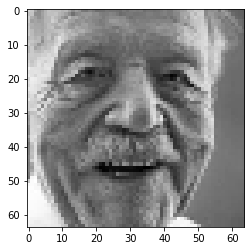

In [258]:
def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()


dir_ = '/content/02582-case2-UTKFace/data/data/Faces' # access pictures at github
count = 0
for path in os.listdir(dir_):
    if os.path.isfile(os.path.join(dir_, path)):
        count += 1
print('File count: ', count)

# get all file names
onlyfiles = os.listdir(dir_)
# reoder the only files based on value
onlyfiles = sorted(onlyfiles, key=lambda x: int(x[:-4]))

X_data = []
for file in onlyfiles:
    face = cv2.imread(dir_+'/' + file)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(face, (64, 64))

    # define custom transform function
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    # get tensor image
    face_tr = transform(face)
    # calculate mean and std
    mean, std = face_tr.mean([1,2]), face_tr.std([1,2])
    # define custom transform function to transform the pIL image to tensor 
    transform_norm = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ]) 
    # get normalized image
    face_normalized = transform_norm(face)
    face_normalized = torch.reshape(face_normalized,[64,64])

    X_data.append(face_normalized)

X_data = np.array(X_data)
X_data.shape

X = np.squeeze(X_data)
plt.imshow(X[0], cmap="gray")

## Prepare train and test set

In [ ]:
path_data = "/content/02582-case2-UTKFace/labels_with_age_group.csv"
data = pd.read_csv(path_data,index_col=0)

encoder = LabelEncoder()
encoder.fit(data["age_group"].unique())
Y = encoder.transform(data["age_group"])

### Solve class imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


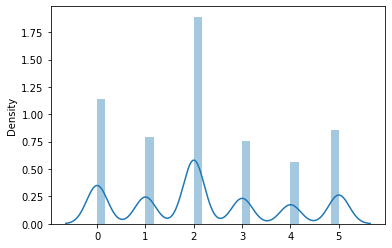

In [ ]:
sns.distplot(Y,kde=True, bins=30)


Too many faces of people between 0(below 18) and 2(25-35) age group. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to solve class imbalance issue by undersampling the data. which is to remove some samples from the two biggest groups.

In [227]:
# Deal with class-imbalance by undersampling by random
from imblearn.under_sampling import RandomUnderSampler
counter=range(0,len(Y))
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(data,Y)
X_index = rus.sample_indices_ # get indices of sampled data
X_data = X_data[X_index]

In [226]:
y_resampled.shape

(13422,)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


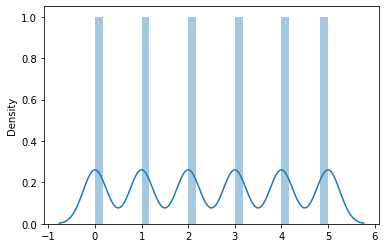

In [228]:
sns.distplot(y_resampled,kde=True, bins=30)

In [229]:
X = X_data
X.resize((13422, 1, 64, 64))
X.shape

(13422, 1, 64, 64)

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
y_test = torch.tensor(y_test, dtype=torch.long).squeeze()
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

In [ ]:
np.unique(Y)

array([0, 1, 2, 3, 4, 5])

## Setup loader

In [ ]:
BATCH_SIZE = 50


# set up a loader for training and test data
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

val_dataset = Data.TensorDataset(X_val, y_val)
val_loader = Data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False)

test_dataset = Data.TensorDataset(X_test, y_test)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False)


## Architecture Design -- CNN

In [ ]:
class netWork(torch.nn.Module):
    def __init__(self):
        super(netWork, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2),),
            
            # Defining a 2D convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),

            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.Dropout(p = 0.5, inplace = True)

        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(4608, 6)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



learning_rate = 0.001
    
model = netWork()     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

## Early stopping

In [ ]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to make early stopping more or less lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=5)

Exited due to early stopping


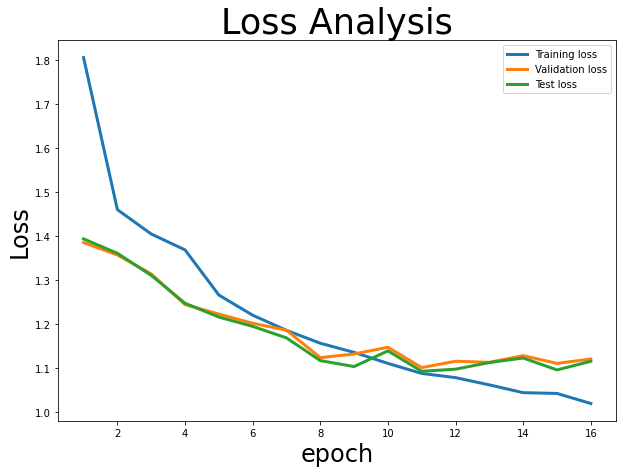

In [ ]:
EPOCH = 50
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in range(EPOCH):
    train_loss_tot = 0 # Save for plotting
    model.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader): # for each training step
        
        predictions = model(inputs_)     # input x and predict based on x
        
        loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    model.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    
    if earlyStopping.step(torch.tensor(val_loss_tot/len(val_dataset)),model):
        print('Exited due to early stopping')
        model = earlyStopping.bestModel
        break  # early stop criterion is met, we can stop now

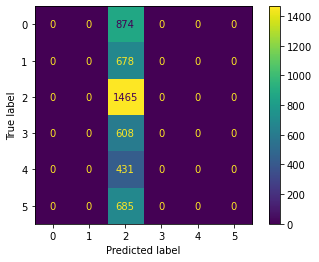

In [ ]:
preds_tot = torch.zeros(len(test_dataset),6)
for s, (inputs_, _) in enumerate(test_loader): # for each testing batch
                
    predictions = model(inputs_)     # input x and predict based on x
    
    endIndex = (BATCH_SIZE*(s+1)) if (BATCH_SIZE*(s+1)) <= len(test_dataset) else len(test_dataset)
    preds_tot[(BATCH_SIZE*s):endIndex,:] = predictions.data
    
preds = np.argmax(preds_tot,axis=1)
cm = confusion_matrix(y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
accuracy_score(y_test, preds)

0.5450326935245728

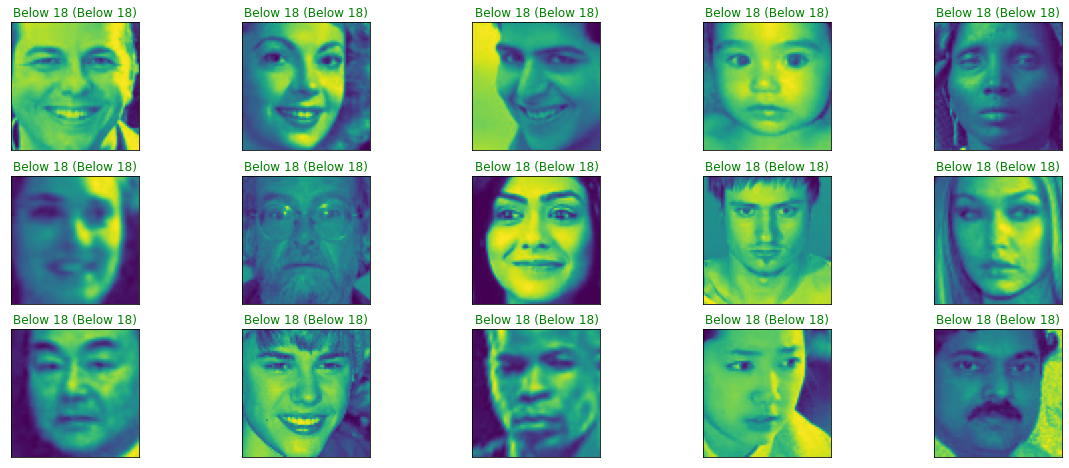

In [ ]:
labels =["Below 18",  # index 0
     "18-25",    # index 1
     "25-35",    # index 2 
     "35-45",    # index 3 
     "45-55",    # index 4
     "Above 55"]  # index 5
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(preds[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index],labels[true_index]),color=("green" if predict_index == true_index else "red"))
plt.show()

In [ ]:
torch.save(model.state_dict(), "CNN_parameter")

## Architecture Design -- ANN

In [ ]:
# ann with 2 layers
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_features, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, n_hidden_features)
        self.relu1 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(n_hidden_features, n_hidden_features)
        self.relu2 = torch.nn.ReLU()

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(64*128, 6),
            torch.nn.ReLU()
        )# output layer
        
    # Defining the forward pass
    def forward(self, x):
      # Linear function 1
      x = self.fc1(x)
      x = self.relu1(x)

      # Linear function 2
      x = self.fc2(x)
      x = self.relu2(x)
      x = x.view(x.size(0), -1) # 尺寸的逻辑：输入层将数据拉平[B,C,H,W] -> [B,C*H*W]
      x = self.linear_layers(x)
      return x

number_of_features = 64
n_hidden_layers = 128
n_output = 6
learning_rate = 0.01
# L2 Regularization is added to the optimizer as weight decay, use a number between 0 and 1
# If more regularization is desired then you can add dropout to the network 
weight_decay = 0.1 #Try changing this
    
net = Net(n_feature = number_of_features, n_hidden_features = n_hidden_layers, n_output = n_output)     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = torch.nn.CrossEntropyLoss()

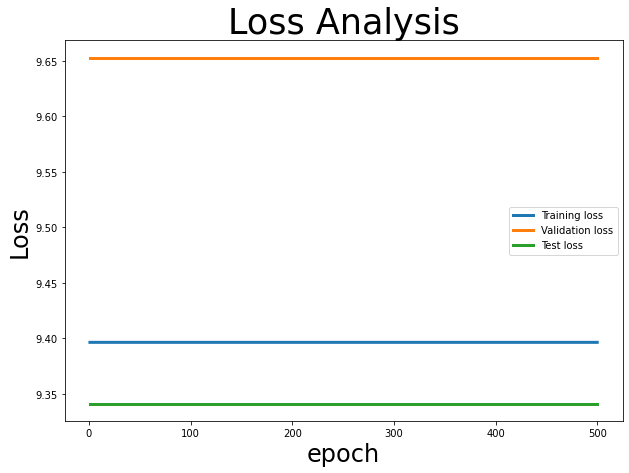

In [ ]:
EPOCH = 500
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in range(EPOCH):
    train_loss_tot = 0 # Save for plotting
    net.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader):
       predictions = net(inputs_)  # input x and predict based on x
       loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
       optimizer.zero_grad()   # clear gradients for next train
       loss.backward()         # backpropagation, compute gradients
       optimizer.step()        # apply gradients 

       #save the loss for plotting
       train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    net.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = net(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = net(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss


    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    
    '''if earlyStopping.step(torch.tensor(val_loss_tot/len(val_dataset)),model):
        print('Exited due to early stopping')
        model = earlyStopping.bestModel
        break  # early stop criterion is met, we can stop now'''

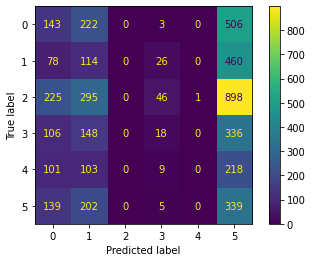

In [ ]:
preds_tot = torch.zeros(len(test_dataset),6)
for s, (inputs_, _) in enumerate(test_loader): # for each testing batch
                
    predictions = net(inputs_)     # input x and predict based on x
    
    endIndex = (BATCH_SIZE*(s+1)) if (BATCH_SIZE*(s+1)) <= len(test_dataset) else len(test_dataset)
    preds_tot[(BATCH_SIZE*s):endIndex,:] = predictions.data
    
preds = np.argmax(preds_tot,axis=1)
cm = confusion_matrix(y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()